In [1]:
import logging
import os
import random
import pprint
import yaml
import numpy as np
import torch
from torch import nn
from source.domain.experiment import (
    get_data,
    evaluate,
    train,
    predict,
    make_loader,
    make_model,
    make_optimizer,
)

# save weights and biases api key to .env file in project directory
assert os.getenv('WANDB_API_KEY')
assert torch.cuda.is_available()

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)  # noqa: NPY002
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

logging.config.fileConfig(
    os.path.join(os.getcwd(), '/code/source/config/logging.conf'),
    # defaults={'logfilename': os.path.join(os.getcwd(), 'tests/test_files/log.log')},
    disable_existing_loggers=False,
)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_file = '/code/source/entrypoints/run_fc_1.yaml'

In [3]:
with open(config_file) as f:
    config = yaml.safe_load(f)

pprint.pprint(config)

{'architecture': 'FC',
 'batch_size': 64,
 'epochs': 40,
 'layers': [500, 100],
 'learning_rate': 0.005,
 'notes': 'First run with a simple fully connected network',
 'num_reduce_learning_rate': 3,
 'optimizer': 'adam',
 'project': 'pytorch-demo-v2',
 'tags': ['pytorch', 'demo']}


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f"Device: {device}")

2023-12-31 23:54:38 - INFO     | Device: cuda:0


---

In [5]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(architecture=config['architecture'])
train_loader = make_loader(x_train, y_train, batch_size=config['batch_size'])
validation_loader = make_loader(x_val, y_val, batch_size=config['batch_size'])
model = make_model(
    architecture=config['architecture'],
    input_size=x_train.shape[1],
    layers=config['layers'] if 'layers' in config else None,
    kernels=config['kernels'] if 'kernels' in config else None,
    device=device,
)
criterion = nn.CrossEntropyLoss()
optimizer_creator = make_optimizer(optimizer=config['optimizer'], model=model)

2023-12-31 23:54:42 - INFO     | Training set  : X-torch.Size([56000, 784]), y-torch.Size([56000])
2023-12-31 23:54:42 - INFO     | Validation set: X-torch.Size([7000, 784]), y-torch.Size([7000])
2023-12-31 23:54:42 - INFO     | Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


FullyConnectedNN(
  (layers): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [6]:
train(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer_creator=optimizer_creator,
    epochs=1, #,config['epochs'],
    learning_rate=config['learning_rate'],
    device=device,
    num_reduce_learning_rate=config['num_reduce_learning_rate'],
    log_wandb=False,
)

2023-12-31 23:54:42 - INFO     | Training on cuda:0; epochs: 1; learning rate: 0.005
  0%|          | 0/1 [00:00<?, ?it/s]2023-12-31 23:54:43 - INFO     | Epoch: 0 | Learning Rate: 0.005
2023-12-31 23:54:43 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 64 examples: 12.804 | 132.542
2023-12-31 23:54:43 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 1,920 examples: 18.159 | 0.906
2023-12-31 23:54:44 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 3,776 examples: 0.767 | 0.628
2023-12-31 23:54:44 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 5,632 examples: 0.535 | 0.428
2023-12-31 23:54:44 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 7,488 examples: 0.471 | 0.447
2023-12-31 23:54:45 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 9,344 examples: 0.438 | 0.445
2023-12-31 23:54:45 - INFO

In [7]:
predictions = predict(model=model, x=x_test, device=device)
print(predictions[0:10])
predictions = predictions.cpu().numpy()
print(predictions[0:10])

tensor([5, 7, 5, 8, 1, 8, 2, 8, 1, 3], device='cuda:0')
[5 7 5 8 1 8 2 8 1 3]


In [8]:
predictions = predict(model=model, x=x_test, device=device, probs=True)
predictions = predictions.cpu().numpy().round(2)
print(predictions[0:10])

[[0.   0.   0.   0.01 0.   0.99 0.   0.   0.   0.  ]
 [0.   0.   0.   0.02 0.   0.   0.   0.88 0.   0.1 ]
 [0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ]
 [0.   0.34 0.02 0.2  0.   0.01 0.   0.02 0.41 0.01]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.06 0.   0.   0.   0.   0.   0.   0.   0.94 0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.05 0.01 0.03 0.   0.01 0.   0.01 0.84 0.03]
 [0.   0.53 0.   0.36 0.   0.   0.   0.11 0.   0.  ]
 [0.   0.   0.01 0.66 0.   0.01 0.   0.   0.33 0.  ]]


2023-12-31 23:54:54 - INFO     | Final Average Loss on training set: 0.226
2023-12-31 23:54:54 - INFO     | Final Average Loss on validation set: 0.239
2023-12-31 23:54:54 - INFO     | Final Average Loss on test set: 0.258
2023-12-31 23:54:55 - INFO     | Weighted Precision: 0.927, Recall: 0.924, F1: 0.925
2023-12-31 23:54:55 - INFO     | Accuracy: 0.924


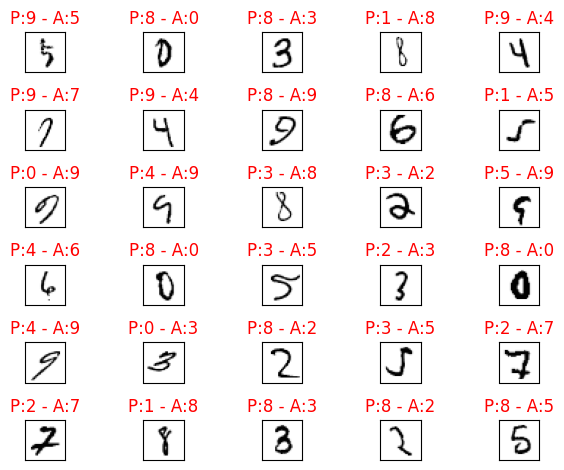

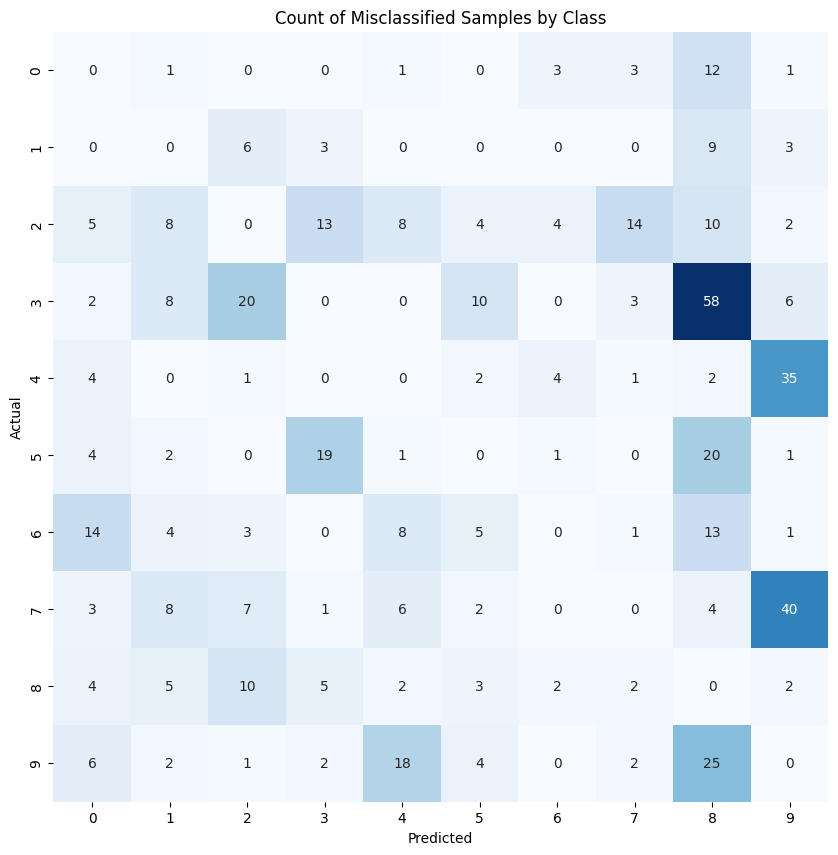

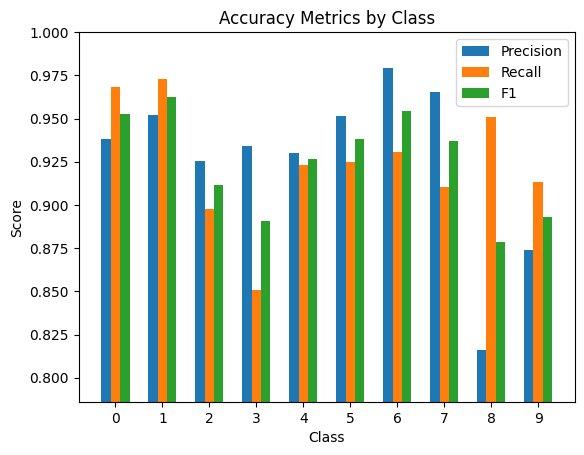

In [9]:
evaluate(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    x_test=x_test,
    y_test=y_test,
    criterion=criterion,
    device=device,
    log_wandb=False,
)